In [1]:
import pandas as pd
import numpy as np
from econometron.Models.dynamicsge import linear_dsge
from econometron.utils.state_space import update_ss
from econometron.utils.estimation.MLE import simulated_annealing_kalman
from econometron.utils.estimation.Bayesian import rwm_kalman,compute_proposal_sigma,make_prior_function
from econometron.filters import kalman_smooth

In [2]:
# Model setup
equations=[ 
           "- r_t + phi*p_t=0",
           "p_t - beta * p_tp1 - kappa * (x_t - xbar_t) = 0",
           "x_t - x_tp1 + (1/g) * (r_t - p_tp1) = 0",
           "- xbar_tp1 + rho * xbar_t + sigmax = 0"]
variables=[ 'r','p','x','xbar']
states=['xbar']
exo_states=['xbar']
shock=['sigmax']
# Parameters dictionary
parameters = {
    'g': 5,      # Inverse of relative risk aversion (1/g)
    'beta': 0.99,       # Discount factor
    'kappa': 0,
    'rho': 0.95,        # Persistence of output gap target
    'phi': 1.5,         # Taylor rule inflation coefficient
    'd': 0.5,          # Calvo parameter
    'sigmax':0.01
}

In [3]:
sigma_X,beta,g,rho,phi,d=parameters['sigmax'],parameters['beta'],parameters['g'],parameters['rho'],parameters['phi'],parameters['d']
parameters['kappa']=((1-d)*(1-d*beta))/d

In [4]:
new_keynisian_model=linear_dsge(equations=equations,variables=variables,exo_states=exo_states,shocks=shock,parameters=parameters)

In [5]:
initial_guess = [1, 1, 1]
new_keynisian_model.set_initial_guess(initial_guess)

In [6]:
new_keynisian_model.compute_ss(initial_guess,method='fsolve',options={'xtol': 1e-10})

Steady-state residuals: [ 0.   -0.    0.   -0.01]


r        0.000000e+00
p        0.000000e+00
x      -4.940656e-324
xbar     0.000000e+00
dtype: float64

In [8]:
A,B,C=new_keynisian_model.approximate(method='analytical')

In [9]:
new_keynisian_model.solve_RE_model()
print("Policy Function (f):\n", new_keynisian_model.f)
print("State Transition (p):\n", new_keynisian_model.p)

Policy Function (f):
 [[-0.64715933]
 [-0.43143956]
 [ 0.94916702]]
State Transition (p):
 [[0.95]]


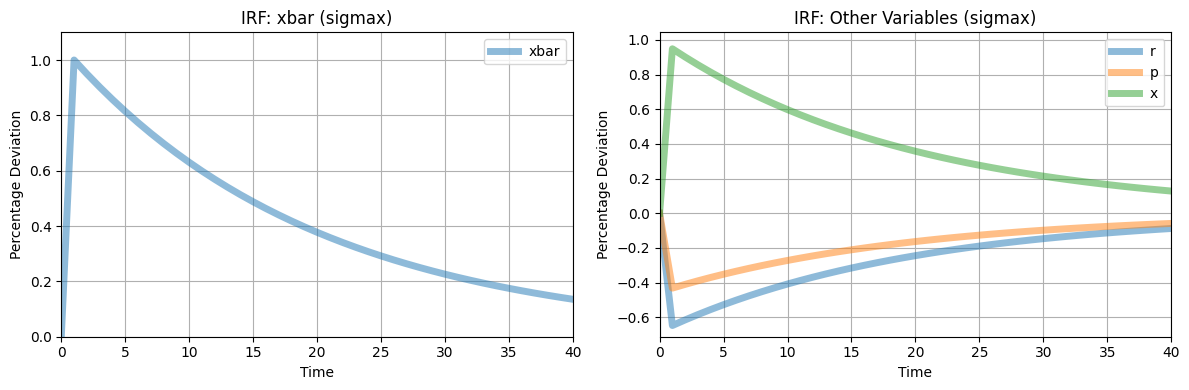

In [10]:
new_keynisian_model.plot_irfs()

In [11]:
new_keynisian_model.simulate(T=100, drop_first=10, covariance_matrix=np.array([[0.01**2]]))

,sigmax_t,xbar_t,r_t,p_t,x_t
0,-0.006156,0.001192,-0.000772,-0.000514,0.001132
1,0.008362,0.009495,-0.006145,-0.004096,0.009012
2,0.008760,0.017780,-0.011506,-0.007671,0.016876
3,-0.011920,0.004971,-0.003217,-0.002145,0.004718
4,0.004438,0.009160,-0.005928,-0.003952,0.008694
...,...,...,...,...,...
95,-0.004246,0.008128,-0.005260,-0.003507,0.007715
96,0.001827,0.009549,-0.006179,-0.004120,0.009063
97,0.001160,0.010232,-0.006621,-0.004414,0.009711
98,-0.012107,-0.002387,0.001545,0.001030,-0.002266


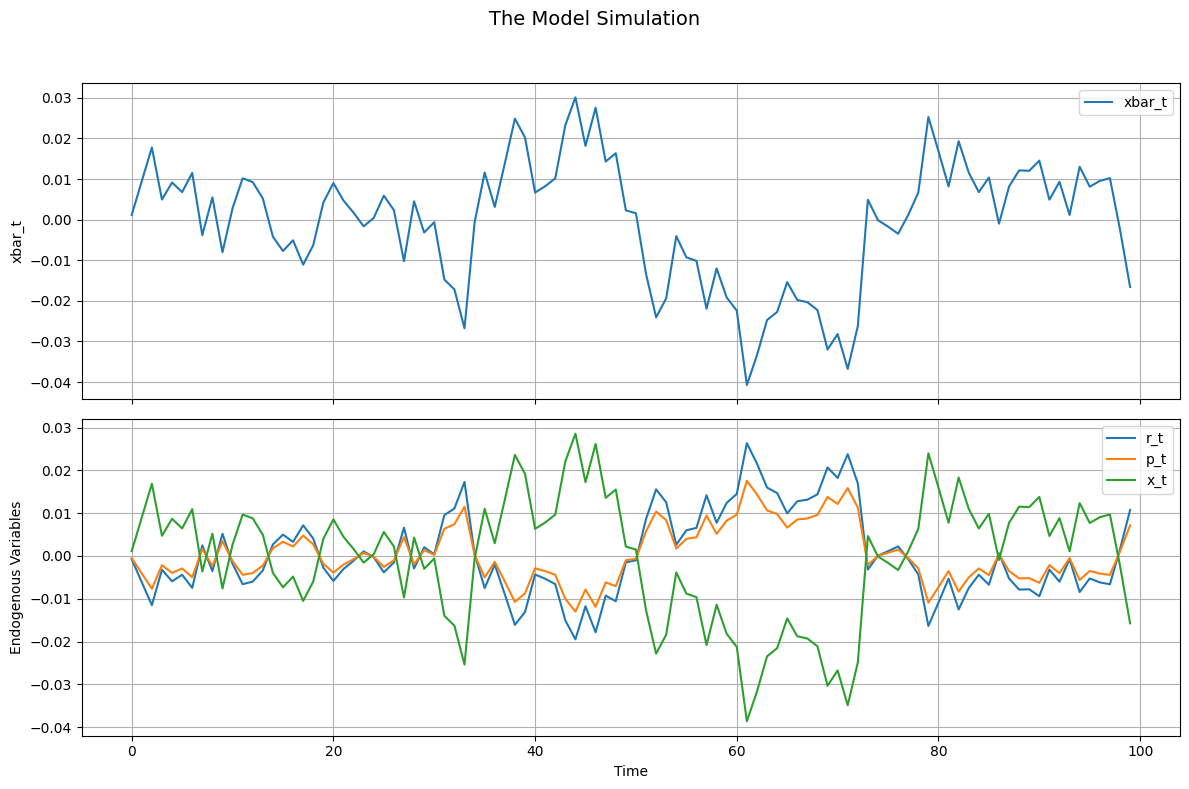

In [12]:
new_keynisian_model.simulations()

In [13]:
GDP=pd.read_csv("../../Data_Fred/gdp.csv", index_col=0, parse_dates=True)
Inflation=pd.read_csv("../../Data_Fred/inflation.csv", index_col=0, parse_dates=True)
Interest_Rate=pd.read_csv("../../Data_Fred/int_rate.csv", index_col=0, parse_dates=True)
mac_data = pd.concat([Interest_Rate, Inflation, GDP], axis=1)
mac_data = mac_data.dropna()
# Rename columns for clarity
mac_data.columns = ['Int', 'Inf', 'GDP']
# Apply log transformation01)
mac_data = np.log(mac_data)
# Remove rows with -inf, inf, or NaN values
mac_data = mac_data.replace([np.inf, -np.inf], np.nan).dropna().transpose()
#int for intrest_rate for simplcity

In [25]:
if not np.all(mac_data.isna().sum()):
    print("All data is good")

All data is good


In [15]:
mac_data.shape

(3, 138)

In [26]:
from econometron.utils.data_preparation import TimeSeriesProcessor

In [27]:
TSP=TimeSeriesProcessor(mac_data.T,method='hodrick_prescott',lamb=1600)

Processing column: Int
  Int final stationarity: False
Processing column: Inf
  Inf final stationarity: False
Processing column: GDP
  GDP final stationarity: False


In [28]:
TSP.get_transformed_data().describe()

,Int,Inf,GDP
count,1.380000e+02,1.380000e+02,1.380000e+02
mean,2.181990e-14,9.894662e-15,-1.207488e-14
std,1.194459e+00,1.172101e+00,7.253189e-01
min,-1.298000e+01,-1.305741e+01,-7.934407e+00
25%,-5.034480e-02,-7.607250e-02,-1.898152e-02
50%,3.724315e-02,7.937725e-02,-1.246645e-03
75%,3.852347e-01,2.855604e-01,1.421629e-02
max,1.096166e+00,1.061262e+00,1.404130e+00


In [29]:
trans_data=TSP.get_transformed_data().T.values

<Axes: xlabel='observation_date'>

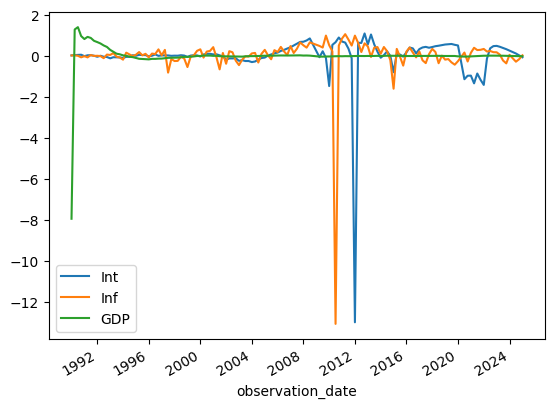

In [30]:
TSP.get_transformed_data().plot()

In [31]:
trans_data.shape

(3, 138)

In [32]:
def derived_fn(p):
    p['kappa'] = ((1 -p['d']) * (1-p['d']*p['beta']))/p['d']
#since we have kappa is written in function of Beta nd delta , the derived_fn here is param fixer , for parameter that are not intialized  
def R_builder(p):
  A1 = np.array([[1, -p['phi'], 0],
                    [0, 1, -p['kappa']],
                    [1/p['g'], 0, 1]])
  if abs(np.linalg.det(A1)) < 1e-6:
    raise ValueError("A1 matrix is singular")
  R1= np.array([[p['sigma_r'], 0, 0],
                [0, p['sigma_p'], 0],
                [0, 0, p['sigma_y']]])
  R=np.linalg.solve(A1,R1)
  return R
def C_builder(p):
    return np.array([[p['sigmax']]])

In [33]:
base_params = {
    'g': 1.00000000e+01,
    'beta': 8.97384125e-01,
    'kappa': 0.8,
    'rho': 9.61923424e-01,
    'phi': 1,
    'd': 8.64607398e-01 ,
    'sigmax': 7.52359617e-03,
    'sigma_y': 0.01,
    'sigma_p': 0.01,
    'sigma_r': 0.01
}
# [1.00000000e+01 8.97384125e-01 9.61923424e-01 1.00000000e+00
#  8.64607398e-01 7.52359617e-03 7.20758075e-03 1.00000000e-06
#  9.97050476e-03]
update_state_space = update_ss.make_state_space_updater(
    base_params=base_params,
    solver=new_keynisian_model.solve_RE_model,
    build_R=R_builder,
    build_C=C_builder,
    derived_fn=derived_fn
)

In [34]:
from econometron.filters import kalman_objective

In [35]:
param_names = [k for k in base_params.keys() if k != 'kappa' and  k != 'beta'] # since Kappa is calulated 
initial_params = [base_params[name] for name in param_names]
fixed_params = {'beta':0.96} # calibrated models 
LB= [0,0,1,0,0,0,0,0]
UB= [10,1,5,1,1,1,1,1]

In [36]:
MLE_Results=simulated_annealing_kalman(trans_data,initial_params ,LB, UB, param_names, fixed_params, update_state_space,seed=1,T0=5,rt=0.9,nt=2,ns=2)

Starting Simulated Annealing with params: T0: 5, rt: 0.9, nt: 2, ns: 2, seed: 1
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
initial loss function value: 3313515.8535972014
current evaluated vector of parameters: 
 [8.34044009405148, 0.961923424, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.30233257263183977, 1, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1.7450408455106836, 0.864607398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.00752359617, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.01, 0.01, 0.01]
current evaluated vector of parameters: 
 [10.0, 0.961923424, 1, 0.6581423464613398, 0.08515706417671388, 0.6852195003967595, 0.01, 0.01]
current eva

KeyboardInterrupt: 

In [26]:
MLE_Results['table']

,Parameter,Estimate,Std Error,P-Value,Log-Likelihood,Method
0,g,3.733802,1.739197e+00,3.180493e-02,-323.794562,Simulated Annealing
1,rho,0.046595,2.126112e-01,8.265290e-01,-323.794562,Simulated Annealing
2,phi,1.000013,7.071068e-20,0.000000e+00,-323.794562,Simulated Annealing
3,d,0.440579,7.176760e-02,8.306105e-10,-323.794562,Simulated Annealing
4,sigmax,0.998331,2.192556e-01,5.281724e-06,-323.794562,Simulated Annealing
5,sigma_y,0.786665,7.585181e-02,0.000000e+00,-323.794562,Simulated Annealing
6,sigma_p,0.999964,1.974920e-01,4.120309e-07,-323.794562,Simulated Annealing
7,sigma_r,0.999999,2.996703e-02,0.000000e+00,-323.794562,Simulated Annealing


In [27]:
from scipy.stats import gamma, beta

In [28]:
param_names = ['g', 'rho','phi', 'd', 'sigmax', 'sigma_y', 'sigma_p', 'sigma_r']
priors = {
    'g':       (gamma, {'a': 5, 'scale': 1}),
    'rho':     (beta, {'a': 19, 'b': 1}),
    'phi':     (gamma, {'a': 3, 'scale': 0.5}),
    'd':       (beta, {'a': 10, 'b': 10}),
    'sigmax':  (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_y': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_p': (gamma, {'a': 2, 'scale': 0.02}),
    'sigma_r': (gamma, {'a': 2, 'scale': 0.02}),
}

bounds = {
    'g':        (0, 10),
    'rho':      (0, 1),
    'phi':      (1, 5),
    'd':        (0, 1),
    'sigmax':   (0, np.inf),
    'sigma_y':  (0, np.inf),
    'sigma_p':  (0, np.inf),
    'sigma_r':  (0, np.inf),
}

# Create the generalized prior function
prior = make_prior_function(param_names, priors, bounds, verbose=True)


In [29]:
params = [5.0,0.95, 1.5, 0.5, 0.04, 0.04, 0.04, 0.04]
logp = prior(params)

[Log Prior] g: logpdf(5.0000) = -1.740
[Log Prior] rho: logpdf(0.9500) = 2.021
[Log Prior] phi: logpdf(1.5000) = -0.803
[Log Prior] d: logpdf(0.5000) = 1.260
[Log Prior] sigmax: logpdf(0.0400) = 2.605
[Log Prior] sigma_y: logpdf(0.0400) = 2.605
[Log Prior] sigma_p: logpdf(0.0400) = 2.605
[Log Prior] sigma_r: logpdf(0.0400) = 2.605
[Total Log Prior] = 11.158 | Params = [5.0, 0.95, 1.5, 0.5, 0.04, 0.04, 0.04, 0.04]


In [30]:
base_std = [0.02,0.02, 0.01, 0.01, 0.002, 0.002, 0.002, 0.002]
sigma = compute_proposal_sigma(len(initial_params), LB,UB, base_std=base_std)

In [31]:
Bayes_res=rwm_kalman(trans_data,initial_params,LB,UB,param_names,fixed_params,update_state_space,n_iter=1000,burn_in=100,thin=1,sigma=sigma,seed=1,prior=prior)

current evaluated vector of parameters: 
 [1.00000000e+01 9.61923424e-01 1.00000000e+00 8.64607398e-01
 7.52359617e-03 1.00000000e-02 1.00000000e-02 1.00000000e-02]
[Bound Error] g = 10.0000 not in (0, 10)
[Log Prior] g: logpdf(9.9966) = -3.966
[Log Prior] rho: logpdf(0.9602) = 2.213
[Log Prior] phi: logpdf(1.0002) = -0.614
[Log Prior] d: logpdf(0.8652) = -5.602
[Log Prior] sigmax: logpdf(0.0073) = 2.539
[Log Prior] sigma_y: logpdf(0.0102) = 2.730
[Log Prior] sigma_p: logpdf(0.0102) = 2.728
[Log Prior] sigma_r: logpdf(0.0101) = 2.724
[Total Log Prior] = 2.753 | Params = [9.99655144e+00 9.60167707e-01 1.00016885e+00 8.65190213e-01
 7.30347233e-03 1.02289447e-02 1.01803181e-02 1.01004989e-02]
current evaluated vector of parameters: 
 [9.99655144e+00 9.60167707e-01 1.00016885e+00 8.65190213e-01
 7.30347233e-03 1.02289447e-02 1.01803181e-02 1.01004989e-02]
[Log Prior] g: logpdf(9.9844) = -3.958
[Log Prior] rho: logpdf(0.9608) = 2.224
[Log Prior] phi: logpdf(1.0069) = -0.614
[Log Prior] d: 

TypeError: create_results_table() got an unexpected keyword argument 'output_dir'

In [ ]:
Bayes_res['table']

In [ ]:
new_set_of_params=MLE_Results['result']

In [ ]:
parameters.update(new_set_of_params)

In [ ]:
Smoothed_state=kalman_smooth(trans_data,parameters,update_state_space)

In [ ]:
new_keynisian_model.set_new_pramaters(new_set_of_params)